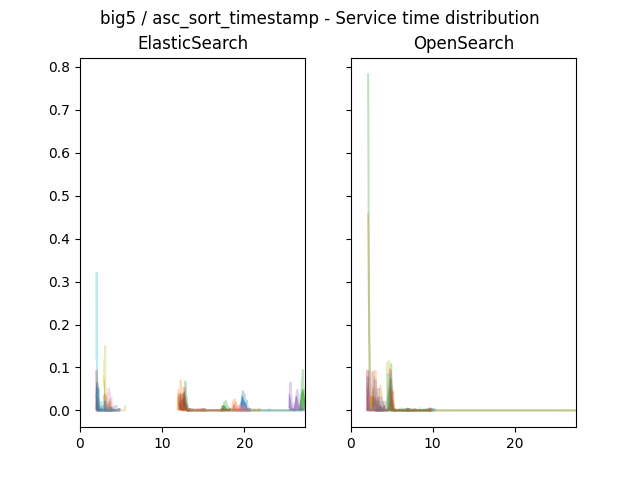

In [10]:
%matplotlib ipympl
%matplotlib widget

import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import IPython.display
import ipywidgets

db = sqlite3.connect("amz_benchmark_data_20241015.sqlite")


def _get_workloads() -> dict[str, list[str]]:
    cur = db.execute(
        "SELECT DISTINCT workload, task FROM runs JOIN tasks ON run_id = id"
    )
    res: dict[str, list[str]] = defaultdict(list)
    for workload, task in cur.fetchall():
        res[workload].append(task)
    return res


workloads = _get_workloads()


def _get_groups(workload: str, distro: str) -> list[str]:
    cur = db.execute(
        "SELECT DISTINCT run_group, run_type, environment FROM runs WHERE workload = :workload AND distribution_version = :dist_ver",
        {
            "workload": workload,
            "dist_ver": distro,
        },
    )
    return [
        (f"{group} ({type} {environment})", group)
        for group, type, environment in cur.fetchall()
    ]


metric = ipywidgets.Dropdown(
    options=[
        ("Latency", "latency"),
        ("Processing time", "processing_time"),
        ("Client processing time", "client_processing_time"),
        ("Service time", "service_time"),
        ("Throughput", "throughput"),
    ],
    description="Metric:",
    value="service_time",
)
workload = ipywidgets.Dropdown(options=list(workloads.keys()), description="Workload:")
task = ipywidgets.Dropdown(options=workloads[workload.value], description="Task:")

groups_es = ipywidgets.SelectMultiple(
    options=_get_groups(workload.value, "8.15.0"), description="ES groups"
)
groups_os = ipywidgets.SelectMultiple(
    options=_get_groups(workload.value, "2.16.0"), description="OS groups"
)

groups = ipywidgets.HBox([groups_es, groups_os])


def _update_tasks(*args):
    groups_es.options = _get_groups(workload.value, "8.15.0")
    groups_os.options = _get_groups(workload.value, "2.16.0")
    task.options = workloads[workload.value]


workload.observe(_update_tasks, "value")


def _get_pop(
    metric: str, workload: str, task: str, dist_ver: str, group: str
) -> list[float]:
    q = f"""
    SELECT runs.id, runs.environment, runs.run_type, "{metric}".value FROM runs JOIN "{metric}" ON "{metric}".run_id = runs.id
    WHERE
        runs.workload = :workload AND
        runs.distribution_version=:dist_ver AND
        runs.run_group = :group AND
        "{metric}".task=:task AND
        "{metric}".sample_type='normal';
    """
    params = {
        "workload": workload,
        "dist_ver": dist_ver,
        "task": task,
        "group": group,
    }
    cur = db.execute(q, params)
    return cur.fetchall()


def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


def _plot(pop: list[tuple[str, str, str, float]], ax):
    if len(pop) == 0:
        return
    values = [value for key, env, type, value in pop]

    density, bins = np.histogram(values, len(pop), density=True)
    unity_density = density / density.sum()
    ax.plot(bins[1:], unity_density, alpha=0.3)
    smooth = moving_average(unity_density, 10)
    smoothx = np.linspace(bins[1:].min(), bins[1:].max(), len(smooth))
    ax.fill_between(smoothx, smooth, alpha=0.7)
    ax.set_xlim(left=0)


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_label("")


def _update_plot(*args):
    fig.suptitle(f"{workload.value} / {task.value} - {metric.label} distribution")

    ax1.clear()
    ax2.clear()
    ax1.set_title("ElasticSearch")
    ax2.set_title("OpenSearch")
    plot_es_groups = (
        [value for label, value in groups_es.options]
        if len(groups_es.value) == 0
        else groups_es.value
    )
    plot_os_groups = (
        [value for label, value in groups_os.options]
        if len(groups_os.value) == 0
        else groups_os.value
    )
    for group in plot_es_groups:
        _plot(_get_pop(metric.value, workload.value, task.value, "8.15.0", group), ax1)
    for group in plot_os_groups:
        _plot(_get_pop(metric.value, workload.value, task.value, "2.16.0", group), ax2)


metric.observe(_update_plot, "value")
workload.observe(_update_plot, "value")
task.observe(_update_plot, "value")
groups_os.observe(_update_plot, "value")
groups_es.observe(_update_plot, "value")

IPython.display.display(ipywidgets.VBox([metric, workload, task, groups]))

_update_plot()